<a href="https://colab.research.google.com/github/BehzadShayeghTry/CIFAR-10-CNN/blob/master/wrapUp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR 10 - CNN

  با سلام. در این پروژه هدف آشنایی با پایتورچ - کانولوشنال نورال نتورک و تاثیر چندی از هایپرپارامتر های آن می باشد. در این پروژه تحلیل ها را بر مبنای آزمون و خطا بر مجموعه داده ی تصویری سیفار۱۰ انجام خواهیم داد.
  
  قبل از شروع به مقایسه های مورد نظر ابتدا ملزمات آزمون ها را آماده می کنیم.

## Requirements to begin

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

برای بهره برداری کامل از پایتورچ لازم است ساختار داده هایمان را به تنسور تبدیل کنیم. پس داده ها را بارگیری کرده و آن ها را در قالب تنسورذخیره می کنیم. داده ها را در قالب بچ سایز های ۳۲ تایی نگهداری می کنیم (این هایپر پارامتر را جلوتر تغییر داده و آن را بررسی می کنیم.) هر بچ درواقه یک بلوک دیتاست که در آموزش شبکه عصبی با هم تاثیر می گذارند.

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


بد نیست قبل از شروع نگاهی به دیتای در دسترسمان داشته باشیم.

In [0]:
import matplotlib.pyplot as plt
import numpy as np

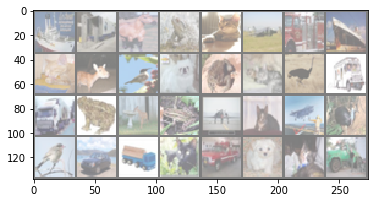

 ship truck horse  frog   cat plane truck  ship
  cat  deer  bird   dog  frog   cat  bird truck
truck  frog  deer  frog plane   cat plane  bird
 bird   car truck   cat truck   dog   cat truck


In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
for i in range(4) :
  print(' '.join('%5s' % classes[labels[8*i+j]] for j in range(8)))

به دلیل حجم زیاد محاسبات تصمیم بر آن است که محاسبات را بر روی سخت افزار

gpu

انجام دهیم :

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
criterion = nn.CrossEntropyLoss()

به دلیل کرات دفعاتی که می خواهیم شبکه هایی بسازیم آن ها را بررسی کنیم توابعی منعطف برای آموزش و تست آن ها پیاده می کنیم که با ورودی خود شبکه ی عصبی و هایپر پارامتر ها کار کنند. ساختمان داده ای داده های آموزش و تست را هم به عنوان ورودی تعبیه می کنیم تا درصورت نیاز به تغییر بر روی این دیتا مجبور به از نو نویسی این توابع یا دستکاری دیتای اصلی نشویم.

In [0]:
def Train(Net, trainloader, epoch_range, lr, momentum, loss_values) :
  optimizer = optim.SGD(Net.parameters(), lr=lr, momentum=momentum) if momentum else optim.SGD(Net.parameters(), lr=lr)

  for epoch in range(epoch_range):
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = Net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

In [0]:
def Test(NET, testloader) :
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = NET(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

In [0]:
def accuracy(net, train=Train, test=Test, trainloader=trainloader, testloader=testloader, epoch_range=5, lr=0.001, momentum=0.9, loss_values=[]) :
  net.to(device)

  %time train(net, trainloader, epoch_range, lr, momentum, loss_values)
  test(net, testloader)

با دستور زمان زمان لازم برای آموزش را دریافت می کنیم. این امر در زمان مقایسه ی شبکه ها بسیار مهم است.

## part 1 : Simple NN

حال زمان شروع به ساختن شبکه های عصبی است. طبق خواسته ی صورت پروژه مجاز به استفاده تنها از سه لابه پنهان هستیم. از ساده ترین حالت شروع می کنیم. یک لایه پنهان خطی و یک لایه خطی خروجی :

In [0]:
class Net1_1(nn.Module):
    def __init__(self):
        super(Net1_1, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
accuracy(Net1_1())

CPU times: user 22.7 s, sys: 5.12 s, total: 27.9 s
Wall time: 56.4 s
Accuracy of the network on the 10000 test images: 44 %


بازدهی تشخیص رندوم برای این دیتاست که حاوی ۱۰ کلاس است ده درصد خواهد بود. پس برای شروع در نقطه ی قابل قبولی ایستاده ایم. با افزایش تعداد نود های لایه ی پنهان تاثیر این هایپر پارامتر را بررسی می کنیم :

In [0]:
class Net1_2(nn.Module):
    def __init__(self):
        super(Net1_2, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [15]:
accuracy(Net1_2())

CPU times: user 22.5 s, sys: 5.08 s, total: 27.6 s
Wall time: 55.8 s
Accuracy of the network on the 10000 test images: 46 %


همانطور که مشاهده می کنید بازدهی کمی افزایش پیدا کرد. پس شاید افزایش بزرگی شبکه همیشه کمک کند. امتحان می کنیم.

در ادامه تعداد لایه های پنهان را به دو لایه ی خطی افزایش می دهیم. تعداد نود ها را نیز افزایش می دهیم.

In [0]:
class Net1_3(nn.Module):
    def __init__(self):
        super(Net1_3, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 512)
        self.fc2 = nn.Linear(512, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
accuracy(Net1_3())

CPU times: user 27.8 s, sys: 5.51 s, total: 33.3 s
Wall time: 1min 1s
Accuracy of the network on the 10000 test images: 43 %


همانطور که انتظار می رفت با افزایش لایه ها زمان آموزش شبکه افزایش پیدا کرد. مورد عجیب و جالب توجه کاهش بازدهی شبکه است. پس بزرگی شبکه همیشه هم کمک نخواهد کرد.

در شبکه ی بالا تعداد نود ها همواره رو به کاهش است. شاید برعکس این موضوع بیشتر کمک کند. پس لایه ای افزایشی قرار می دهیم :

In [0]:
class Net1_4(nn.Module):
    def __init__(self):
        super(Net1_4, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 120)
        self.fc2 = nn.Linear(120, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
accuracy(Net1_4())

CPU times: user 27 s, sys: 5.29 s, total: 32.3 s
Wall time: 59.9 s
Accuracy of the network on the 10000 test images: 44 %


مشاهده می شود که تاثیر چندان زیادی مشاهده نمی کنیم. می توان نتیجه گرفت که لایه های خطی از حدی بیشتر نمی توانند کمک کنند. پس به سراغ لایه های کانولوشن خواهیم رفت «

In [0]:
class Net1_5(nn.Module):
    def __init__(self):
        super(Net1_5, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(12 * 11 * 11, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 12 * 11 * 11)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [25]:
accuracy(Net1_5())

CPU times: user 30.4 s, sys: 5.09 s, total: 35.5 s
Wall time: 1min 2s
Accuracy of the network on the 10000 test images: 50 %


همانطور که مشاهده شد و انتظار می رفت لایه ی کانولوشن به خوبی کمک می کند و همچنین گرچه زمان آموزش را بالا می برد اما این افزایش نسبت به افزایش بازدهی معقول می رسد.

بار دیگر تعداد نود ها را کاهش می دهیم بلکه زمان آموزش کاهش پیدا کند.

In [0]:
class Net1_6(nn.Module):
    def __init__(self):
        super(Net1_6, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(12 * 11 * 11, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 12 * 11 * 11)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [27]:
accuracy(Net1_6())

CPU times: user 28.7 s, sys: 5.16 s, total: 33.8 s
Wall time: 1min
Accuracy of the network on the 10000 test images: 50 %


همانطور که مشاهده شد زمان آموزش تا حد کمی کاهش پیدا کرد.

حال که لایه ی کانولوشن تا این حد یاری رسان بود شاید خوب باشد اگر تعداد بیشتری لایه ی کانولوشن داشته باشیم:

In [0]:
class Net1_7(nn.Module):
    def __init__(self):
        super(Net1_7, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 10)
        self.conv2 = nn.Conv2d(12, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [29]:
accuracy(Net1_7())

CPU times: user 35.9 s, sys: 5.13 s, total: 41.1 s
Wall time: 1min 5s
Accuracy of the network on the 10000 test images: 43 %


مشاهده می شود که این عمل نه تنها کمکی نکرد بلکه هم زمان آموزش را بالا برد هم درصد بازدهی را!

شاید تعداد بعد های لایه های کانولوشن بتواند تاثیر بگذارد. ممکن است تاثر بد مشاهده شده در قسمت قبل به دلیل کم بودن تعداد نود ها بود.

In [0]:
class Net1_8(nn.Module):
    def __init__(self):
        super(Net1_8, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 8)
        self.conv2 = nn.Conv2d(16, 24, 8)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(24 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 24 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [31]:
accuracy(Net1_8())

CPU times: user 34.8 s, sys: 5.08 s, total: 39.9 s
Wall time: 1min 4s
Accuracy of the network on the 10000 test images: 47 %


گرچه تاثیر گذار بود اما همچنان بازدهی کمی نصبت به یک لایه کانولوشن دارد. تعداد نود ها را افزایش می دهیم

In [0]:
class Net1_9(nn.Module):
    def __init__(self):
        super(Net1_9, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 4)
        self.conv2 = nn.Conv2d(16, 24, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(24 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 24 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [33]:
accuracy(Net1_9())

CPU times: user 36.1 s, sys: 5.39 s, total: 41.4 s
Wall time: 1min 5s
Accuracy of the network on the 10000 test images: 50 %


به نصبت زمانی که صرف کرد تاثیر قابل قبولی بر بازدهی داشت.

بار دیگر تعداد بعد را کاهش می دهیم. شاید تاثیر افزایش تعداد نود و بعد همپوشانی داشته باشند.

In [0]:
class Net1_10(nn.Module):
    def __init__(self):
        super(Net1_10, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 4)
        self.conv2 = nn.Conv2d(8, 12, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(12 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 12 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [35]:
accuracy(Net1_10())

CPU times: user 36.4 s, sys: 5.32 s, total: 41.7 s
Wall time: 1min 6s
Accuracy of the network on the 10000 test images: 47 %


برخلاف احتمالی که دادیم افزایش نود ها و بعد ها هرکدام جداگانه تاثیر مثبت گذاشته بودند.

پس تعداد بعد ها را به صورت قابل توجهی افزایش می دهیم:

In [0]:
class Net1_11(nn.Module):
    def __init__(self):
        super(Net1_11, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 4)
        self.conv2 = nn.Conv2d(16, 128, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [37]:
accuracy(Net1_11())

CPU times: user 36.6 s, sys: 5.64 s, total: 42.2 s
Wall time: 1min 7s
Accuracy of the network on the 10000 test images: 53 %


همانطور که انتظار می رفت تاثیر خوبی مشاهده شد.

شاید حالا که تعداد بعد به اندازه کافی زیاد است لایه ی کانولوشن اضافی کمک کند :

In [0]:
class Net1_12(nn.Module):
    def __init__(self):
        super(Net1_12, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 4)
        self.conv2 = nn.Conv2d(16, 128, 2)
        self.conv3 = nn.Conv2d(128, 564, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(564 * 2 * 2, 564)
        self.fc2 = nn.Linear(564, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 564 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [39]:
accuracy(Net1_12())

CPU times: user 48.3 s, sys: 5.68 s, total: 54 s
Wall time: 1min 14s
Accuracy of the network on the 10000 test images: 39 %


با توجه به این نتیجه و نتیجه نتورک 1-7 متوجه می شویم اضافه کردن لایه ی کانولوشن باید با دقت انجام بگیرد.

یک شبکه عصبی با هایپر پارامتر های اضافی تر نیز امتحان می کنیم :

In [0]:
class Net1_13(nn.Module):
    def __init__(self):
        super(Net1_13, self).__init__()
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(18 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 18 * 16 *16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)

In [41]:
accuracy(Net1_13())

CPU times: user 28.5 s, sys: 5.45 s, total: 34 s
Wall time: 1min
Accuracy of the network on the 10000 test images: 54 %


نصبت به اندازه ی شبکه تاثیر خوبی داشت.

شبکه را کمی بزرگ تر امتحان می کنیم :

In [0]:
class Net1_14(nn.Module):
    def __init__(self):
        super(Net1_14, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 256 * 16 *16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)

In [58]:
accuracy(Net1_14())

CPU times: user 50.8 s, sys: 27.8 s, total: 1min 18s
Wall time: 1min 32s
Accuracy of the network on the 10000 test images: 58 %


چشم گیر است.

### 1_1 : Change initial weights

شبکه عصبی را یکبار با مقدار دهی تمام وزن ها به صفر امتحان می کنیم. از شبکه عصبی 1-11 استفاده می کنیم:

In [0]:
class Net1_11_1(nn.Module):
    def __init__(self):
        super(Net1_11_1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 4)
        self.conv2 = nn.Conv2d(16, 128, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)

        self.conv1.weight.data.fill_(0.00)
        self.conv1.bias.data.fill_(0.00)
        self.conv2.weight.data.fill_(0.00)
        self.conv2.bias.data.fill_(0.00)
        self.fc1.weight.data.fill_(0.00)
        self.fc1.bias.data.fill_(0.00)
        self.fc2.weight.data.fill_(0.00)
        self.fc2.bias.data.fill_(0.00)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [60]:
accuracy(Net1_11_1())

CPU times: user 36.6 s, sys: 5.69 s, total: 42.3 s
Wall time: 1min 6s
Accuracy of the network on the 10000 test images: 10 %


بازدهی این روش در حد پیشبینی رندوم است این امر بنظر معقول می رسد چرا که درصورتی که وزن ها دارای مقدار صفر باشند در به روز رسانی ها هیچوقت تغییری نمی کنند. زیرا در روش بهینه سازی ما این مقدار قبلی وزن ها باید در مقداری ضرب شود و وقتی این مقدار برابر صفر باشد تغییرات همواره صفر خواهد بود. اما درصورت مقدار دهی اولیه رندوم داریم :

In [0]:
class Net1_11_2(nn.Module):
    def __init__(self):
        super(Net1_11_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 4)
        self.conv2 = nn.Conv2d(16, 128, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)

        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [62]:
accuracy(Net1_11_2())

CPU times: user 36.4 s, sys: 5.73 s, total: 42.1 s
Wall time: 1min 6s
Accuracy of the network on the 10000 test images: 57 %


و مشاهده می شود که نتیجه بسیار بهتر است.

## Part 2 : 2 Layer with one Conv

در این بخش می خواهیم فقط از شبکه هایی با یک لایه پنهان کانولوشن استفاده کنیم و بهترین اندازه ی فیلتر را بدست آوریم. برای این کار تابعی برای ساختن این شبکه ها با دریافت هایپر پارامتر ها تعریف می کنیم :

In [0]:
from math import floor

In [0]:
def net1C1L(dim, node, poolSize=2, activation_function=F.relu) :
  class Net2(nn.Module):
      def __init__(self):
          super(Net2, self).__init__()
          self.conv = nn.Conv2d(3, dim, node)
          self.pool = nn.MaxPool2d(poolSize, poolSize)
          self.fc = nn.Linear(floor(dim * (32-node)/poolSize * (32-node)/poolSize), 10)

          nn.init.xavier_uniform_(self.conv.weight)
          nn.init.xavier_uniform_(self.fc.weight)

      def forward(self, x):
          x = self.pool(activation_function(self.conv(x)))
          x = x.view(-1, floor(dim * (32-node)/poolSize * (32-node)/poolSize))
          x = self.fc(x)
          return x
        
  return Net2()

قبل از آزمودن فیلتر ها سعی می کنیم بهترین اندازه ی شبکه را بدست آوریم :

In [65]:
accuracy(net1C1L(16, 4)) #net2_1

CPU times: user 25.2 s, sys: 5.73 s, total: 30.9 s
Wall time: 59.2 s
Accuracy of the network on the 10000 test images: 54 %


In [66]:
accuracy(net1C1L(8, 4)) #net2_2

CPU times: user 25.4 s, sys: 5.66 s, total: 31.1 s
Wall time: 59.1 s
Accuracy of the network on the 10000 test images: 49 %


In [67]:
accuracy(net1C1L(24, 4)) #net2_3

CPU times: user 25.5 s, sys: 5.71 s, total: 31.2 s
Wall time: 59.2 s
Accuracy of the network on the 10000 test images: 55 %


In [68]:
accuracy(net1C1L(64, 4)) #net2_4

CPU times: user 25.9 s, sys: 5.81 s, total: 31.8 s
Wall time: 60 s
Accuracy of the network on the 10000 test images: 56 %


In [69]:
accuracy(net1C1L(256, 4)) #net2_5

CPU times: user 30 s, sys: 9.68 s, total: 39.6 s
Wall time: 1min 3s
Accuracy of the network on the 10000 test images: 55 %


In [70]:
accuracy(net1C1L(64, 8)) #net2_6

CPU times: user 25.9 s, sys: 5.49 s, total: 31.3 s
Wall time: 59.5 s
Accuracy of the network on the 10000 test images: 54 %


In [71]:
accuracy(net1C1L(64, 12)) #net2_7

CPU times: user 25.9 s, sys: 5.33 s, total: 31.2 s
Wall time: 59.4 s
Accuracy of the network on the 10000 test images: 51 %


In [72]:
accuracy(net1C1L(64, 2)) #net2_8

CPU times: user 25 s, sys: 5.27 s, total: 30.3 s
Wall time: 58.5 s
Accuracy of the network on the 10000 test images: 52 %


پس بهترین اندازه برای 64 و 4 بود. حال به دنبال بهترین اندازه ی فیلتر بر روی شبکه ای با این اندازه می گردیم. توجه کنید که ممکن است برای قابل انجام بودن محاسبات گاهی از این اعداد کمی ناپیروی خواهیم کرد.

In [73]:
accuracy(net1C1L(64, 5, poolSize=3)) #net2_9

CPU times: user 25.2 s, sys: 5.22 s, total: 30.4 s
Wall time: 58.4 s
Accuracy of the network on the 10000 test images: 55 %


In [74]:
accuracy(net1C1L(64, 4, poolSize=4)) #net2_10

CPU times: user 25.3 s, sys: 6 s, total: 31.3 s
Wall time: 59.8 s
Accuracy of the network on the 10000 test images: 53 %


In [75]:
accuracy(net1C1L(64, 4, poolSize=7)) #net2_11

CPU times: user 25.3 s, sys: 6.08 s, total: 31.3 s
Wall time: 59.9 s
Accuracy of the network on the 10000 test images: 51 %


مشاهده می شود که افزایش اندازه ی فیلتر باعث کاهش بازدهی می شود و این امر بدیهی است چرا که فیلتر بخشی از دیتا را حذف می کند :

## Part 3 : Normalization

در این بخش می خواهیم تاثیر نرمالایز کردن دیتا را بر بازدهی و زمان آموزش بررسی کنیم. پس سه نتورکی که در بخش های قبل بهتر بودند را امتحان می کنیم. توجه شود که نرمالایز کردن باید بدون درنظر گرفتن لیبل ها باشد زیرا در غیر این صورت دچار اورفیت خواهیم شد. ابتدا بار دیگر عملکرد بدون نرمالایز کردن دیتا را برای آنها مشاهده می کنیم :

In [77]:
accuracy(Net1_6())

CPU times: user 27.5 s, sys: 5.08 s, total: 32.6 s
Wall time: 59.4 s
Accuracy of the network on the 10000 test images: 50 %


In [78]:
accuracy(Net1_14())

CPU times: user 52.1 s, sys: 31.8 s, total: 1min 23s
Wall time: 1min 32s
Accuracy of the network on the 10000 test images: 58 %


In [79]:
accuracy(net1C1L(64, 4)) #net2_4

CPU times: user 24 s, sys: 5.97 s, total: 29.9 s
Wall time: 57.8 s
Accuracy of the network on the 10000 test images: 56 %


حال دیتا را این بار به صورتی ساده نرمالایز کرده و در ساختمان داده ای جدید ذخیره می کنیم و آن ها را به عنوان آرگومان برای آموزش و تست به نتورک های بالا می دهیم و عملکرد را مقایسه می کنیم :

In [80]:
transform3_1 = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset3_1 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform3_1)
trainloader3_1 = torch.utils.data.DataLoader(trainset3_1, batch_size=32, shuffle=True, num_workers=2)

testset3_1 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform3_1)
testloader3_1 = torch.utils.data.DataLoader(testset3_1, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [81]:
accuracy(Net1_6(), trainloader=trainloader3_1, testloader=testloader3_1)

CPU times: user 29.7 s, sys: 5.19 s, total: 34.9 s
Wall time: 1min 13s
Accuracy of the network on the 10000 test images: 56 %


In [82]:
accuracy(Net1_14(), trainloader=trainloader3_1, testloader=testloader3_1)

CPU times: user 52.4 s, sys: 23.9 s, total: 1min 16s
Wall time: 1min 33s
Accuracy of the network on the 10000 test images: 65 %


In [83]:
accuracy(net1C1L(64, 4), trainloader=trainloader3_1, testloader=testloader3_1) #net2_4

CPU times: user 26.6 s, sys: 6.92 s, total: 33.5 s
Wall time: 1min 12s
Accuracy of the network on the 10000 test images: 61 %


مشاهده می شود که در این فرایند زمان آموزش کمی افزایش پیدا کرده ولی بازدهی الگوریتم بالاتر می رود.

یکبار دیگر کار بالا را این بار با نرمالایز کردن با هایپر پارامتر هایی غیر بدیهی امتحان می کنیم. این هایپر پارامتر ها نیز باید تاثیر زیاده داشته باشند :

In [84]:
transform3_2 = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

trainset3_2 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform3_2)
trainloader3_2 = torch.utils.data.DataLoader(trainset3_2, batch_size=32, shuffle=True, num_workers=2)

testset3_2 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform3_2)
testloader3_2 = torch.utils.data.DataLoader(testset3_2, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [85]:
accuracy(Net1_6(), trainloader=trainloader3_2, testloader=testloader3_2)

CPU times: user 30.1 s, sys: 5.3 s, total: 35.4 s
Wall time: 1min 14s
Accuracy of the network on the 10000 test images: 58 %


In [86]:
accuracy(Net1_14(), trainloader=trainloader3_2, testloader=testloader3_2)

CPU times: user 52.6 s, sys: 23.9 s, total: 1min 16s
Wall time: 1min 34s
Accuracy of the network on the 10000 test images: 66 %


In [87]:
accuracy(net1C1L(64, 4), trainloader=trainloader3_2, testloader=testloader3_2) #net2_4

CPU times: user 27 s, sys: 6.87 s, total: 33.9 s
Wall time: 1min 13s
Accuracy of the network on the 10000 test images: 65 %


و باز هم بازدهی بالا تر و کمی زمان آموزش بیشتر (۱ ثانیه). پس مقدار این هایپر پارامتر ها نیز به صورت قابل توجهی تاثیر گذار است.

## Part 4 : Learning Rate

در این بخش به بررسی هایپر پارامتر تاثیر گذار لرنینگ ریت می پردازیم. برای این کار تابع آموزش را تغییر می دهیم تا مقدار خطا را به نحوی ذخیره کند تا بتوانیم با نمودار حاصل از آن این موضوع را تحلیل کنیم. این موضوع را برای شبکه ی 2-4 بدون نرمالایز کردن دیتا بررسی می کنیم:

In [0]:
def TrainWithLossValues(Net, trainloader, epoch_range, lr, momentum, loss_values) :
  optimizer = optim.SGD(Net.parameters(), lr=lr, momentum=momentum) if momentum else optim.SGD(Net.parameters(), lr=lr)

  for epoch in range(epoch_range):
    for step, data in enumerate(trainloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = Net(inputs)
      loss = criterion(outputs, labels)
      loss_values.append(loss.item())
      loss.backward()
      optimizer.step()

In [89]:
loss1 = []
accuracy(net1C1L(64, 4), train=TrainWithLossValues, lr=0.1, loss_values=loss1) #net2_4

CPU times: user 25.5 s, sys: 7.37 s, total: 32.8 s
Wall time: 59.3 s
Accuracy of the network on the 10000 test images: 10 %


In [90]:
loss01 = []
accuracy(net1C1L(64, 4), train=TrainWithLossValues, lr=0.01, loss_values=loss01) #net2_4

CPU times: user 26 s, sys: 7.26 s, total: 33.2 s
Wall time: 1min
Accuracy of the network on the 10000 test images: 57 %


In [91]:
loss001 = []
accuracy(net1C1L(64, 4), train=TrainWithLossValues, lr=0.001, loss_values=loss001) #net2_4

CPU times: user 26.7 s, sys: 7.23 s, total: 34 s
Wall time: 1min 1s
Accuracy of the network on the 10000 test images: 55 %


In [92]:
loss0001 = []
accuracy(net1C1L(64, 4), train=TrainWithLossValues, lr=0.0001, loss_values=loss0001) #net2_4


CPU times: user 26.5 s, sys: 7.15 s, total: 33.7 s
Wall time: 1min
Accuracy of the network on the 10000 test images: 38 %


مشاهده می شود که زمان آموزش تغییری نمی کند. زیرا این هایپر پارامتر بر مسیر انجام الگوریتم تاثیری نمی گذارد و فقط بر مقدار ضرایب تاثیر دارد.

In [93]:
plt.figure(figsize=(16, 4))

plt.subplot(141)
plt.plot(loss1, 'b^')
plt.xlabel('batch')
plt.ylabel('loss')
plt.title('loss with lr = 0.1')

plt.subplot(142)
plt.plot(loss01, 'r^')
plt.xlabel('batch')
plt.ylabel('loss')
plt.title('loss with lr = 0.01')

plt.subplot(143)
plt.plot(loss001, 'y^')
plt.xlabel('batch')
plt.ylabel('loss')
plt.title('loss with lr = 0.001')

plt.subplot(144)
plt.plot(loss0001, 'g^')
plt.xlabel('batch')
plt.ylabel('loss')
plt.title('loss with lr = 0.0001')

plt.show()

مشاهده می شود که با بی از اندازه کوچک بودن این پارامتر ما هرگز به جواب نزدیک نمی شویم یا خیلی کند به سمت آن حرکت می کنیم زیرا هر بار از محدوده ای به محدوده ای بسیار دور تر پرش می کنیم (از نظر مقدار ضرایب) و این دقت کار را از ما می گیرد.

از طرفی اگر این پارامتر بیش از اندازه کوچک نیز باشد آنقدر حرکت ما را کند می کند که خطای ما با سرعت مطلوبی کاهش پیدا نمی کند. پس لازم است برای این پارامتر مقداری متعادل و کارا پیدا کنیم. همانطور مشخص است این پارامتر بر روی پاسخ تاثیر آشکاری دارد.

برای این شبکه مشاهده می شود که مقدار ۰.۰۱ مقدار کارامدی است.

## Part 5 : Batch Size

در این بخش به بررسی هایپر پارامتر تاثیر اندازه ی بچ می پردازیم. برای این کار شبکه ی 2-4 را با مقدار اندازه ی بچ ۳۲ و ۶۴ و ۲۵۶ بررسی می کنیم.

In [94]:
accuracy(net1C1L(64, 4)) #net2_4

CPU times: user 25.2 s, sys: 5.98 s, total: 31.2 s
Wall time: 59.3 s
Accuracy of the network on the 10000 test images: 56 %


In [0]:
trainloader5_1 = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader5_1 = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [96]:
accuracy(net1C1L(64, 4), trainloader=trainloader5_1, testloader=testloader5_1) #net2_4

CPU times: user 15.4 s, sys: 5.02 s, total: 20.4 s
Wall time: 47.8 s
Accuracy of the network on the 10000 test images: 51 %


In [0]:
trainloader5_2 = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)
testloader5_2 = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)

In [98]:
accuracy(net1C1L(64, 4), trainloader=trainloader5_2, testloader=testloader5_2) #net2_4

CPU times: user 5.65 s, sys: 2.96 s, total: 8.61 s
Wall time: 37.1 s
Accuracy of the network on the 10000 test images: 40 %


مشاهده می شود که با زیاد شدن این پارامتر بازدهی کاهش می یابد اما زمان آموزش به صورت چشم گیری بهتر می شود. این امر طبیعیست چرا که زیاد شدن این متغیر به معنی صبر کردن و اعمال کردن تاثیر بخش زیادی از آموزش به صورت یکباره است و این یعنی کاهش محاسبات و افزایش تقریب.

با توجه با استدلال بالا با افزایش بچ سایز باید لرنینگ ریت را نیز افزایش داد تا دقت از دست رفته تا حدی جبران گردد و تغییرات هر مرحله دوباره تا حد معقولی کاهش پیدا کند.

با توجه به صحبت بالا باید با کم کردن اندازه ی بچ به بازدهی بهتری برسیم :

In [0]:
trainloader5_3 = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)
testloader5_3 = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

In [100]:
accuracy(net1C1L(64, 4), trainloader=trainloader5_3, testloader=testloader5_3) #net2_4

CPU times: user 10min 38s, sys: 2min 1s, total: 12min 40s
Wall time: 15min 9s
Accuracy of the network on the 10000 test images: 45 %


بر خلاف انتظار کوچک بودن این مقدار همیشه هم به دقت بالا کمک نمی کند. و توجه شود که زمان آموزش را به چه حد بالایی افزایش داده است!

این نتیجه برای لرنینگ ریت کوچک 0.001 بود. طبق انتظار باید با تبدیل لرنینگ ریت به 0.01 به نتیجه ی بهتری برسیم.

In [101]:
accuracy(net1C1L(64, 4), trainloader=trainloader5_3, testloader=testloader5_3, lr=0.01) #net2_4

CPU times: user 10min 40s, sys: 2min 3s, total: 12min 43s
Wall time: 15min 6s
Accuracy of the network on the 10000 test images: 10 %


مشاهده می شود که بچ سایز کوچک درهرحال ناموفق است.

## Part 6 : Activation Function

در این بخش تابع فعال سازی را تغییر می دهیم تا به بهترین مورد برسیم. این بررسی را بر روی شبکه ی 2-4 با دیتای بدون نذمالایز انجام می دهیم :

In [102]:
accuracy(net1C1L(64, 4, activation_function=F.tanh)) #net2_4

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


CPU times: user 25.7 s, sys: 6.01 s, total: 31.7 s
Wall time: 1min
Accuracy of the network on the 10000 test images: 52 %


In [103]:
accuracy(net1C1L(64, 4, activation_function=F.relu)) #net2_4

CPU times: user 25.3 s, sys: 6.12 s, total: 31.4 s
Wall time: 1min
Accuracy of the network on the 10000 test images: 54 %


In [104]:
accuracy(net1C1L(64, 4, activation_function=F.leaky_relu)) #net2_4

CPU times: user 25.2 s, sys: 6.22 s, total: 31.5 s
Wall time: 1min
Accuracy of the network on the 10000 test images: 54 %


In [105]:
accuracy(net1C1L(64, 4, activation_function=F.softplus)) #net2_4

CPU times: user 25 s, sys: 6.14 s, total: 31.1 s
Wall time: 59.7 s
Accuracy of the network on the 10000 test images: 38 %


مشاهده می شود که برای این مورد دسته بندی تابع

leaky_relu

بهترین نتیجه را می دهد.

## Part 7 : Momentum

حال زمان بررسی تاثیر هایپر پارامتر مومنتوم می باشد. شبکه ی عصبی 2-4 را بدون نرمالایز کردن دیتا با تابع فعالساز

leaky_relu

بدون مومنتوم و با مومنتوم 0.9 بررسی می کنیم :

In [107]:
accuracy(net1C1L(64, 4, activation_function=F.leaky_relu), momentum=False) #net2_4

CPU times: user 23.3 s, sys: 6.5 s, total: 29.8 s
Wall time: 58.6 s
Accuracy of the network on the 10000 test images: 38 %


In [108]:
accuracy(net1C1L(64, 4, activation_function=F.leaky_relu)) #net2_4

CPU times: user 24.9 s, sys: 6.14 s, total: 31 s
Wall time: 59.5 s
Accuracy of the network on the 10000 test images: 55 %


مشاهده می شود که حضور مومنتوم تا چه حد زیادی می تواند کمک کند و این موضوع استنباط ریاضی پیچیده دارد.

## Best Choice

با توجه به مجموع نتایج به دست آمده در قسمت های این گزارش می توان حدس زد بین مواردی که بررسی شد شبکه ی عصبی 1-14 با خصوصیات زیر می تواند بهترین عملکرد را از نظر بازدهی داشته باشد :

  * نرمالایز 3-2
  * بچ سایز متوسط
  * leaky_relu تابع فعال ساز 
  * مقدار دهی اولیه رندوم وزن ها

In [0]:
trainloader8 = torch.utils.data.DataLoader(trainset3_2, batch_size=32, shuffle=True, num_workers=2)
testloader8 = torch.utils.data.DataLoader(testset3_2, batch_size=32, shuffle=False, num_workers=2)

In [0]:
class Net8(nn.Module):
    def __init__(self):
        super(Net8, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)

        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = x.view(-1, 256 * 16 *16)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return(x)

In [125]:
accuracy(Net8(), trainloader=trainloader8, testloader=testloader8)

CPU times: user 51 s, sys: 21.2 s, total: 1min 12s
Wall time: 1min 34s
Accuracy of the network on the 10000 test images: 65 %
